In [2]:
%pylab inline
#Import packages
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import root#,curve_fit
from scipy.stats import kurtosis
from scipy.signal import savgol_filter
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import rcParams
#rcParams.update({'font.size': 8})
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['axes.labelsize'] = 8
#matplotlib.rcParams['axes.labelweight'] = 'bold'
matplotlib.rc('xtick', labelsize=6)     
matplotlib.rc('ytick', labelsize=6)
import itertools
import pickle

import Parameters as param
import Constant_JGRpaper as cst

#colors:
Red = '#ED2224'
Orange = '#FBB263'
Green = '#A2D39E'
Blue = '#15B4E9'
Purple = '#6B52A2'

Populating the interactive namespace from numpy and matplotlib


In [47]:
"""
Define functions
"""
def dy_dt(t,y):
    '''Define dimensionalized function
    input:
    - t = time vector
    - matrice containing initial head and channel cross-section area
    - L = conduit length
    - Pi = ice pressure
    output:
    - head timeserie
    - channel cross-section area time serie  '''
    # print(f'y: {y}')
    h = y[0] #(–) S*: Non dimentionalized channel cross-section area
    S = y[1] #(–) h*: Non dimentionalized moulin head
    #A_R(z)
    A_R = AR_func(h)    
    #R(t)
    Rt = R_func(t)
    #Head partial differential equation
    dhdt = 1/A_R * ( Rt - cst.C3*S**(5/4)*np.sqrt((cst.rhow*cst.g*h)/param.L) )
    #Channel cross section area partial differential equation
    dSdt = cst.C1 * cst.C3 * S**(5/4) * ((cst.rhow*cst.g*h)/param.L)**(3/2) - cst.C2 * ( param.Pi - cst.rhow*cst.g*h )**cst.n * S
    return [dhdt, dSdt]

def dy_dt_heq(t,y):
    ''' Define dimensionalized function '''
    # print(f'y: {y}')
    h = y[0] #(–) S*: Non dimentionalized channel cross-section area
    S = y[1] #(–) h*: Non dimentionalized moulin head
    #A_R(z)
    A_R = np.pi*r_heq**2
    #R(t)
    Rt = param.R_mean
    #Head partial differential equation
    dhdt = 1/A_R * ( Rt - cst.C3*S**(5/4)*np.sqrt((cst.rhow*cst.g*h)/param.L) )
    #Channel cross section area partial differential equation
    dSdt = cst.C1 * cst.C3 * S**(5/4) * ((cst.rhow*cst.g*h)/param.L)**(3/2) - cst.C2 * ( param.Pi - cst.rhow*cst.g*h )**cst.n * S
    return [dhdt, dSdt]

def dydt(y):
    return np.diff(y,append=0)

def calculate_dt(t):
    return np.diff(t,append=0)

def calculate_df(f):
    return np.diff(f,append=0)

def calculate_dz(z):
    return np.diff(z,append=0)

def calculate_dx(x):
    return np.diff(x,append=0)

def AR_func(h):
    ##A_R(h) for cone
#   return gnp.pi * (m*h + r_base)**2    
    ##AR(h) for r(z)
    r = np.interp(h,z_moulin,r_moulin)    
    return np.pi*r**2

def calculate_Qout(S,hw):
    return cst.C3 * S**(5/4) * np.sqrt( cst.rhow*cst.g*hw/param.L)
    
def R_func(t):
    ##R_constant
    #return p['R_mean']
    ##R_sin
    return (param.R_mean- param.R_min) * np.sin(2.*np.pi*t/param.R_period) + param.R_mean
    ##R_timeserie
    #return np.interp(t,t_timeserie,R_timeserie)
    
def diamond(dh1,dh2, r_else):
    ''' This function produces a vector of moulin radius and a position vector 
    z, upward from the base of the moulin.
    '''
    h_min = h_eq - dh1
    h_max = h_eq + dh2
    
    z = np.array([0,h_min,h_eq,h_max,param.H])
    r = np.array([r_else,r_else,r_heq,r_else,r_else])
    return [z,r]
    
def rectangle(dh1,dh2, r_else):
    ''' This function produces a vector of moulin radius and a position vector 
    z, upward from the base of the moulin.
    '''
    
    h_min = h_eq - dh1
    h_max = h_eq + dh2
    
    z = np.array([0, h_min-0.01, h_min, h_max])#, h_max+0.01, param.H])
    r = np.array([r_else, r_else,  r_heq, r_heq])#,  r_else,r_else])
    return [z,r]

def cylinder(radius):
    ''' This function produces a vector of moulin radius and a position vector 
    z, upward from the base of the moulin.
    '''
    
    z = np.array([0, param.H])
    r = np.array([radius,radius])
    return [z,r]

def cone(r_fix, z_fix, m):
    ''' This function produces a vector of moulin radius and a position vector 
    z, upward from the base of the moulin.
    '''
        #def calc_r_linear(zi,m,r_fix,z_fix):
            #r_base = r_fix-m*z_fix
            #return m*zi+r_base
        #r_top = calc_r_linear(H,m,r_fix,z_fix)
        #r_base = calc_r_linear(0,m,r_fix,z_fix) 

    r_bottom = r_fix-m*z_fix
    r_top = m*param.H+r_bottom
    z = np.array([0, param.H])
    r = np.array([r_bottom,r_top])
    return [z,r]
    
def calculate_f(h):
    AR = AR_func(h)
    R = param.R_mean
    Vob_moulin = (cst.rhoi/cst.rhow)*AR*param.H #volume of water to fill moulin up to overburden pressure
    Vheq_moulin = AR*h_eq
    TauStorage = Vob_moulin/R #mean residence time of the water in the moulin
    TauRes = Vheq_moulin/R
    return TauStorage/cst.secinday #TauRes/cst.secinday : frequency

def find_idx(array, value):
    array = np.asarray(array)
    return (np.abs(array - value)).argmin()

def get_index_slice(start_1=1.5,start_2=2.5,start_5=5.5,end_a=0.5,end_b=0,peak_decalage=20): #start_1a=2.1,start_1b=1.7,end_1b=0.9,end_1a=1.7
    '''Pre-slice last portion of the timeseries'''
    idx_start_1 = find_idx(td,td[-1]-start_1*cst.secinday) #extract index 1.5 days after end of timeserie 
    idx_start_2 = find_idx(td,td[-1]-start_2*cst.secinday) #extract index 2.5 days after end of timeserie 
    idx_start_5 = find_idx(td,td[-1]-start_5*cst.secinday) #extract index 5.5 days after end of timeserie 
    idx_end_a = find_idx(td,td[-1]-end_a*cst.secinday) #extract index 0.5 days after end of timeserie 
    idx_end_b = find_idx(td,td[-1]-end_b*cst.secinday) #extract index 0.5 days after end of timeserie 

    '''peak index'''
    idxpeak = find_idx(hd,max(hd[idx_start_1:idx_end_a]))
                       
    idx1 = [idx_start_1,idx_end_a] # this portion if for calculation
    idx2 = [idx_start_2,idx_end_b] # this portion is for visualisation
    idx5 = [idx_start_5,idx_end_b] # this portion is for visualisation
    idxpeaks = [idxpeak-peak_decalage,idxpeak+peak_decalage] # this portion if for calculation
    
    return idx1,idx2,idx5,idxpeaks, idxpeak 

def f_and_d2hdt():

    '''Dimensionless storage frequency'''
    f = calculate_f(hd)
    f_minmax = f[idxpeak]
    
    '''Kurtosis'''
    kurk_peak = kurtosis(hd[idxpeaks[0]:idxpeaks[1]],fisher=True)
       

    '''Peakedness with second derivative
    -------------------------------------
    A possible different measure of peakedness is the max of the absolute
    value of the 2nd derivative. I'm sure the actual value of this measure
    will depend on the amount of smoothing. However, if we use the same
    window and polynomial order for the filter, then we should get
    values that can be compared to each other. '''

    #2nd derivative of the smoothed signal
    #d2hd_hmin = savgol_filter(hd, 21, 5,deriv=2)
    #d2hd_heq = savgol_filter(hd, 11, 5,deriv=2)
    d2hd = savgol_filter(hd-700, 21, 5,deriv=2) 
    #max at the portion
    #d2hd_hmin_max = max(abs(d2hd_hmin[idxmin[0]:idxmin[1]]))
    #d2hd_heq_max = max(abs(d2hd_heq[idxheq[0]:idxheq[1]]))
    d2hd_max = max(abs(d2hd[idxpeaks[0]:idxpeaks[1]]))
        
    return f, f_minmax, d2hd, d2hd_max, kurk_peak #kurk_hmin, kurk_heq,d2hd_hmin_max, d2hd_heq_max, d2hd_hmin, d2hd_heq,

def df_dz(f,z,h_eq):
    return calculate_df(f)/calculate_f(h_eq)/calculate_dz(z)   

def df_dz_up(f,z,h_eq):
    f_heq=calculate_f(h_eq)
    f_H=calculate_f(param.H)
    f_up=[f_heq,f_H]
    z_up=[h_eq,param.H]
    dfdz = df_dz(f_up,z_up,h_eq)
    return dfdz[1]

def df_dt(f,t):
    return calculate_df(f)/calculate_dt(t)

def calculate_amplitude(hd,h_eq):
    return hd[idxpeak]-h_eq




def plot_complex_fig(idx_start,idx_end,y_ax5):
    
    '''Head timeserie'''
    ax1.plot(td[idx_start:idx_end]/cst.secinday,hd[idx_start:idx_end],color=colors[i],linestyle=linestyles[i],linewidth=linewidths)# marker = next(marker),markevery=50
    ax1.set_ylim([500,param.H])
    ax1.set_ylabel('$h$ (m)')#,rotation='horizontal')
    ax1.get_yaxis().set_label_coords(-0.07,0.7)
    ax1.set_yticks([600,700,800,900,1000]) 
    ax1.set_yticklabels([600,700,800,900,1000])
    ax1.axes.xaxis.set_visible(False)
    ax1.spines['left'].set_bounds(600,1000)

    
    '''Moulin profile'''
    ax2.plot(r_moulin,z_moulin,color=colors[i],linestyle=linestyles[i],linewidth=linewidths)
    ax2.plot(-r_moulin,z_moulin,color=colors[i],linestyle=linestyles[i],linewidth=linewidths) 
    ax2.set_ylabel('$z$ (m)')#,rotation='horizontal')
 

    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax2.set_yticks([200,400,600,800,1000]) 
    ax2.set_yticklabels([200,400,600,800,1000])
    ax2.set_ylim([0,param.H])
    ax2.set_xticks([-15,-10,-5,0,5,10,15]) 
    ax2.set_xticklabels([-15,-10,-5,0,5,10,15])
    ax2.set_xlim(-20,20)
    ax2.fill(polygon_1[0],polygon_1[1],facecolor='#3990AC', alpha=0.05)
    ax2.fill(polygon_2[0],polygon_2[1],facecolor='#3990AC', alpha=0.08)
    ax2.spines['right'].set_bounds(200,1000)
    ax2.spines['bottom'].set_bounds(-15,15)

    '''S'''
    ax3.plot(td[idx_start:idx_end]/cst.secinday,Sd[idx_start:idx_end],color=colors[i], 
             linestyle=linestyles[i],linewidth=linewidths)
    ax3.set_ylabel('$S$ (m$^2$)')#,rotation='horizontal')
    ax3.get_yaxis().set_label_coords(-0.07,0.7)
    ax3.set_ylim(1.1,1.35)
    ax3.set_yticks([1.2,1.3]) 
    ax3.set_yticklabels([1.2,1.3])
    ax3.axes.xaxis.set_visible(False)
    ax3.spines['left'].set_bounds(1.2,1.3)
    
    
    '''QQ and AR timeserie'''

    ax4.semilogy(td[idx_start:idx_end]/cst.secinday,f[idx_start:idx_end],color=colors[i], 
                 linestyle=linestyles[i],linewidth=linewidths)
    ax4.set_ylabel('$f^*$(--)')#,rotation='horizontal')
    
    ax4.set_ylim([8e-4,2e1])
    ax4.set_yticks([1e-2,1e-1,1e0,1e1]) 
    ax4.set_yticklabels([0.01,0.1,1,10])
    ax4.spines['left'].set_bounds(0.01,10)
    ax4.spines['bottom'].set_bounds(44.4,50)

    color = 'dimgrey'
    size = 1.5
    linewidth = 1
    
    '''Comparison f with peakedness'''
    ax5.semilogx(f_minmax_vec,d2hd_max_vec,color=color, linestyle='-.', linewidth=linewidth, zorder=1)
    ax5.semilogx(f_heq_vec,d2hd_max_vec,color=color, linestyle='--', linewidth=linewidth,zorder=1)
    ax5.semilogx(f_average_vec,d2hd_max_vec,color=color, linestyle='-', linewidth=linewidth,zorder=1)

    ax5.semilogx(f_minmax,d2hd_max,color=colors[i],marker='o',markersize=size,zorder=2)
    ax5.semilogx(f_heq,d2hd_max,color=colors[i], marker='o',markersize=size,zorder=2)
    ax5.semilogx((f_minmax+f_heq)/2,d2hd_max,color=colors[i], marker='o',markersize=size,zorder=2)
 
    ax5.yaxis.tick_right()
    ax5.yaxis.set_label_position("right")
    ax5.set_ylabel('$\kappa$ (m/s$^2$)')#,rotation='horizontal')

    ax5.set_xlim([0.0001,20])         
    ax5.set_xticks([0.01,0.1,1,10]) 
    ax5.set_xticklabels([0.01,0.1,1,10])
    ax5.set_ylim([-0.1,1.7])
    ax5.set_yticks([0,0.5,1,1.5]) 
    ax5.set_yticklabels([0,0.5,1,1.5])
    
    ax5.spines['right'].set_bounds(0,1.5)
    ax5.spines['bottom'].set_bounds(0.01,10)
    ax5.tick_params(which='minor', width=0)  

    
    ax6.semilogx(f_minmax_vec,a_vec,color=color, linestyle='-.', linewidth=linewidth,zorder=1)#, linestyle='',marker='^',fillstyle='none', markersize=5)
    ax6.semilogx(f_heq_vec,a_vec,color=color, linestyle='--', linewidth=linewidth,zorder=1)#, linestyle='',marker='o',fillstyle='none', markersize=5)
    ax6.semilogx(f_average_vec,a_vec,color=color, linestyle='-', linewidth=linewidth,zorder=1)#, linestyle=':',marker='*', markersize=7)# f average

    ax6.semilogx(f_minmax,a,color=colors[i], marker='o',markersize=size,zorder=2)
    ax6.semilogx(f_heq,a,color=colors[i], marker='o',markersize=size,zorder=2)
    ax6.semilogx((f_minmax+f_heq)/2,a,color=colors[i], marker='o',markersize=size,zorder=2)
    
    ax6.yaxis.tick_right()
    ax6.yaxis.set_label_position("right")
    ax6.set_ylabel('$a$ (m)')#,rotation='horizontal')
    ax6.set_ylim([-10,350])
    ax6.set_yticks([0,100,200,300]) 
    ax6.set_yticklabels([0,100,200,300])
    ax6.set_xlim([0.0001,20])
    ax6.set_xticks([0.01,0.1,1,10]) 
    ax6.set_xticklabels([0.01,0.1,1,10])
    
    ax6.spines['right'].set_bounds(10,300)
    ax6.spines['bottom'].set_bounds(0.01,10)
    ax6.tick_params(which='minor', width=0)    
        
    '''Add dots to Head timeserie graph'''
    #ax1.plot(td[idxpeaks[0]]/cst.secinday,hd[idxpeaks[0]],'.',color='k')
    #ax1.plot(td[idxpeaks[1]]/cst.secinday,hd[idxpeaks[0]],'.',color='k')


    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)    
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)  
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)   
    ax5.spines['top'].set_visible(False)
    ax5.spines['left'].set_visible(False)
    ax5.spines['bottom'].set_visible(False)
    ax6.spines['top'].set_visible(False)
    ax6.spines['left'].set_visible(False)
    
    ax1.tick_params(direction='in')
    ax2.tick_params(direction='in')
    ax3.tick_params(direction='in')
    ax4.tick_params(direction='in')
    ax5.tick_params(direction='in')
    ax6.tick_params(direction='in')
    
    ax1.patch.set_alpha(0)
    ax2.patch.set_alpha(0)
    ax3.patch.set_alpha(0)
    ax4.patch.set_alpha(0)
    ax5.patch.set_alpha(0)
    ax6.patch.set_alpha(0)
    
def add_letters(a='a',b='b',c='c',d='d',e='e',f='f',g='g',h='h') :   
    ax1.text(0.07, 0.98, a, ha='right', va='top', transform=ax1.transAxes,fontsize=8, 
             bbox=dict(facecolor='white', edgecolor='none', pad=1.0))
    ax3.text(0.07, 0.98, b, ha='right', va='top', transform=ax3.transAxes,fontsize=8, 
             bbox=dict(facecolor='white', edgecolor='none', pad=1.0))
    ax4.text(0.07, 0.98, c, ha='right', va='top', transform=ax4.transAxes,fontsize=8, 
             bbox=dict(facecolor='white', edgecolor='none', pad=1.0))
    ax2.text(0.1, 0.98, d, ha='right', va='top', transform=ax2.transAxes,fontsize=8, 
             bbox=dict(facecolor='white', edgecolor='none', pad=1.0))
    ax5.text(0.9, 0.9, e, ha='right', va='top', transform=ax5.transAxes,fontsize=8, 
             bbox=dict(facecolor='white', edgecolor='none', pad=1.0))
    ax6.text(0.9, 0.9, f, ha='right', va='top', transform=ax6.transAxes,fontsize=8, 
             bbox=dict(facecolor='white', edgecolor='none', pad=1.0))
    
def add_label(position='none'):
    if position=='none':
        
        ax2.set_title('Moulin profile',fontsize=10)
        ax2.set_xlabel('r')
        ax4.set_xlabel('Days')  
        ax5.set_xlabel('$f^*$')
        ax6.set_xlabel('$f^*$')

        
    if position=='middle':
        ax2.tick_params(labelbottom=False) 
        ax4.tick_params(labelbottom=False) 
        ax5.tick_params(labelbottom=False, bottom=False, which='both')
        ax6.tick_params(bottom=False, which='minor') 
        ax6.tick_params(labelbottom=False, which='both')

    if position=='bottom':
        ax2.set_xlabel('r')
        ax4.set_xlabel('Days')
        ax6.set_xlabel('$f^*(h_{peak})$'' full and ''$f^*(h_{eq})$ empty')
    
    if position=='top':
        ax2.tick_params(labelbottom=False) 
        ax4.tick_params(labelbottom=False) 
        ax5.tick_params(labelbottom=False) 
        ax6.tick_params(labelbottom=False) 
        ax2.set_title('Moulin profile',fontsize=10)
    
'''Calculate h_eq'''
r_heq = 5 # this is a random value to calculate h_eq, moulin properties do not influence h_eq
tmp = solve_ivp(dy_dt_heq,(param.t0, 50*cst.secinday),(param.h0,param.S0),method = 'LSODA',max_step = 10*60)
h_eq=tmp.y[0][-1]  

linewidths = 2

resdict ={}
reslist = []

width = 7.4 #5#7.28346 #185mm + 5mm titles
height = 1.6 #1.653544 # 210mm/5 + 20mm bordure haut-bas
figsize_none = (width,height)
#figsize_top = (7.18,height)#-height*0.0683
#figsize_bottom = (7.18,height+height*0.072)
#figsize_middle = (7.18,height-height*0.072)#-height*0.2079

gs_y=4
gs_x=6

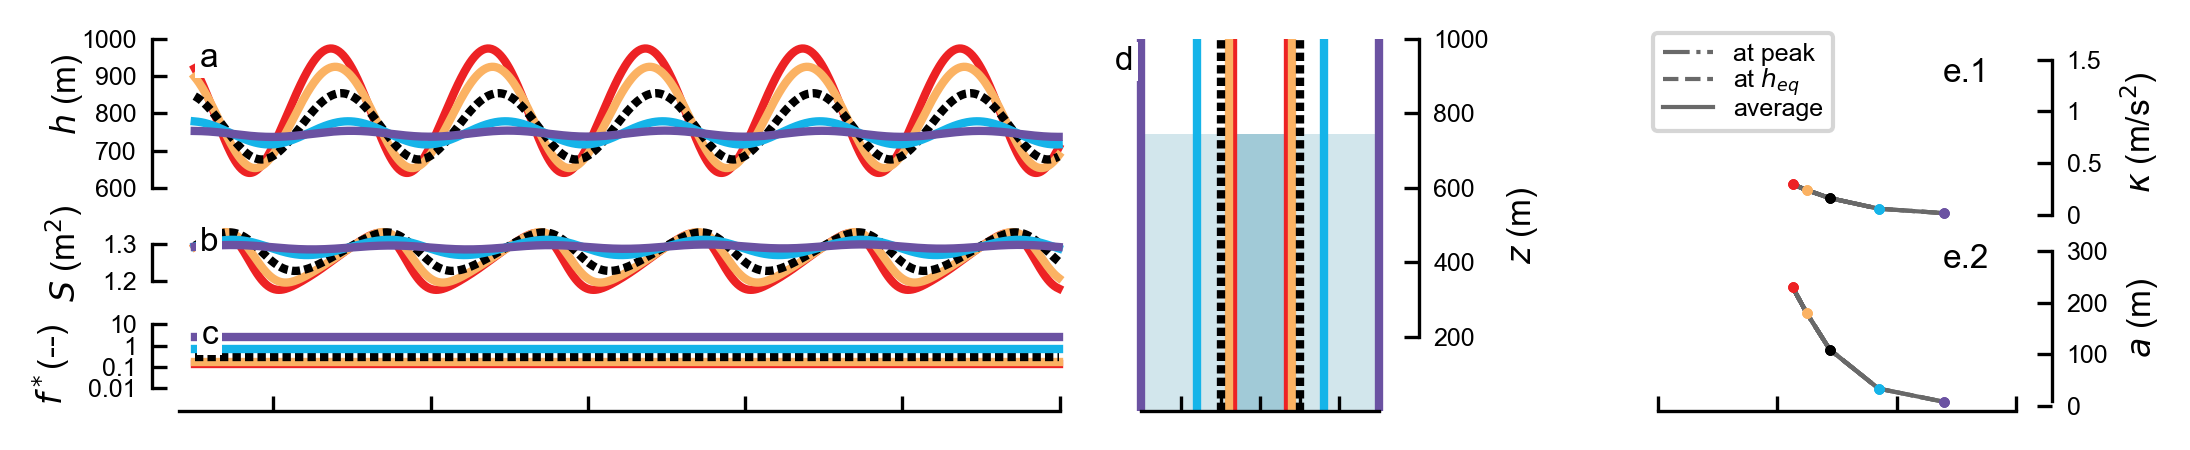

In [48]:
## CYLINDER [3.5,4,5,8,15]
r_heq = 5
#r_elsevec = [4,5,8,19]#np.linspace(4,15,4)#4Colors
r_elsevec = [3.5,4,5,8,15]#5Colors
#param.R_min = 2.7

dh1 = param.H-h_eq#265 #distance from h_eq
dh2 = param.H-h_eq
#linestyles = ('solid',(0, (1, 0.5)),'solid','solid')#4Colors
linestyles = ('solid','solid',(0, (1, 0.5)),'solid','solid')
#colors = ((0,0,0),(0.2,0.2,0.2),(0.4,0.4,0.4),(0.7,0.7,0.7)) #4Colors
colors = (Red, Orange,(0,0,0), Blue, Purple)

#plt.figure()
fig = plt.figure(figsize=figsize_none, dpi=param.dpi, tight_layout=True)
grid = plt.GridSpec(gs_y, gs_x, wspace=0, hspace=0)
ax1 = fig.add_subplot(grid[0:2, :3])#,xticklabels=[]
ax2 = fig.add_subplot(grid[0:, 3])#, sharey=ax1)# , yticklabels=[])
ax3 = fig.add_subplot(grid[2, :3], sharex=ax1)
ax4 = fig.add_subplot(grid[3, :3], sharex=ax1)
ax5 = fig.add_subplot(grid[0:2, 4:])
ax6 = fig.add_subplot(grid[2:4, 4:])
#ax5 = fig.add_subplot(grid[0:2, 3])
#ax6 = fig.add_subplot(grid[2:4, 3], sharex=ax5)
#ax7 = fig.add_subplot(grid[0:2, 4])
#ax8 = fig.add_subplot(grid[2:4, 4], sharex=ax7)

polygon_1 = [[-r_elsevec[-1], r_elsevec[-1], r_elsevec[-1], -r_elsevec[-1]]
             ,[0, 0, h_eq, h_eq,]]

polygon_2 = [[-r_elsevec[0], r_elsevec[0], r_elsevec[0], -r_elsevec[0] ]
             ,[0, 0, h_eq, h_eq]]

d2hd_max_vec = []
a_vec = []
f_heq_vec = []
f_minmax_vec = []
f_average_vec = []

for i,r_else in zip(range(len(r_elsevec)),r_elsevec): #for diamond
  
    tmp = cylinder(r_else)
    z_moulin = tmp[0]
    r_moulin = tmp[1]
    

    r_min = r_else # for the plot with t_min

    
    sol = solve_ivp(dy_dt,(param.t0, param.tf),(param.h0,param.S0),method = 'LSODA',max_step = 10*60)
    hd = sol.y[0]
    Sd = sol.y[1]
    td = sol.t
    
    '''Extract index 1,2 and 5 days '''
    [idx1,idx2,idx5,idxpeaks, idxpeak] = get_index_slice(
        start_1=1.5,start_2=2.5,start_5=5.5,end_a=0.5,end_b=0,peak_decalage=20)
     
    [f, f_minmax, d2hd, d2hd_max, kurk_peak] = f_and_d2hdt()
    #print(f)
    AR = AR_func(hd)
    Qin = R_func(td)
    Qout = calculate_Qout(Sd,hd)
    QQ = Qin-Qout
    dt = calculate_dt(td)
    dhdt = dydt(hd)
    dadt = dhdt/dt
    
    dfdt = df_dt(f,td)
    dfdz_up = df_dz_up(f,z_moulin,h_eq)

    a = calculate_amplitude(hd,h_eq)
    f_heq = calculate_f(h_eq)
    
    d2hd_max_vec.append(d2hd_max)
    a_vec.append(a)
    f_heq_vec.append(f_heq)
    f_minmax_vec.append(f_minmax)
    f_average_vec.append((f_heq+f_minmax)/2)
    #plt.plot(td,dhdt)
    #plt.plot(td,dadt)
    plot_complex_fig(idx5[0],idx5[1],QQ)

    #plt.plot(f_minmax,amplitude,'o')
    
    resdic ={'z_moulin':z_moulin, 'r_moulin':r_moulin,\
              'hd':hd, 'Sd':Sd, 'td':td, 'f':f,\
              'AR':AR, 'Qin':Qin, 'Qout':Qout}
    reslist.append(resdic)

    
elements = [Line2D([0], [0], color='dimgrey', ls='-.', lw=1, label='at peak'),
            Line2D([0], [0], color='dimgrey', ls='--', lw=1, label='at $h_{eq}$'),
            Line2D([0], [0], color='dimgrey', ls='-',  lw=1, label='average')]
ax5.legend(handles=elements, loc=2, bbox_to_anchor=(0.35, 1.1), labelspacing=0,  prop={'size': 6})

#ax2.text(1.2, 1.15, '$z$ (m)', ha='right', va='top', transform=ax2.transAxes,fontsize=8, 
#         bbox=dict(facecolor='white', edgecolor='none', pad=1.0))
#ax5.text(1.2, 1.15,'$\kappa$ (m/s$^2$)', ha='right', va='top', transform=ax5.transAxes,fontsize=8, 
#         bbox=dict(facecolor='white', edgecolor='none', pad=1.0))
#ax6.text(1.15, 1.15, '$a$ (m)', ha='right', va='top', transform=ax6.transAxes,fontsize=8, 
#         bbox=dict(facecolor='white', edgecolor='none', pad=1.0))

add_letters(a='a',b='b',c='c',d='d',e='e.1',f='e.2',g='e.3',h='e.4')
add_label(position='middle')


plt.savefig('Figures/OR_cylinder.pdf')




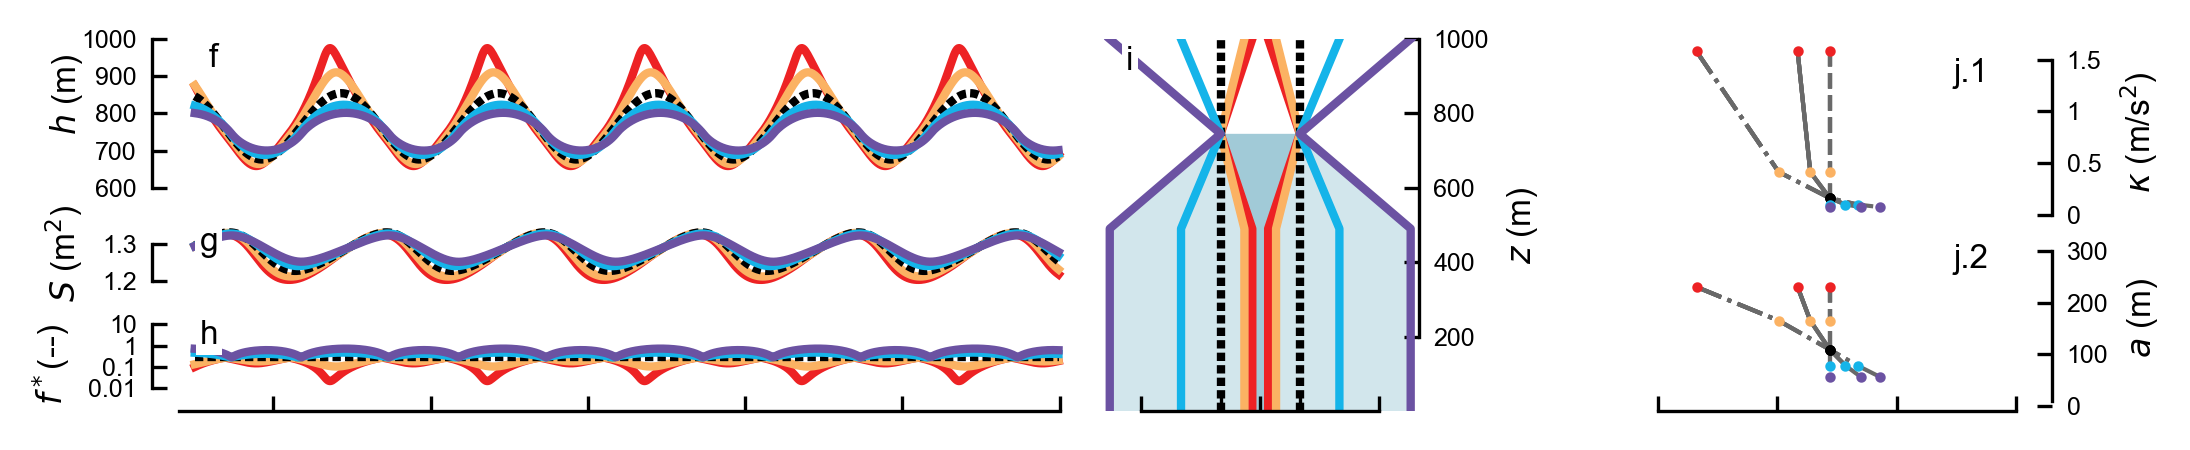

In [49]:
## LOSANGE [1,2,5,10,19]
r_heq = 5 #7
#r_elsevec = [1,2,5,19]#[1,1.5,3,5,10,15] # 4 colors
r_elsevec = [1,2,5,10,19]#[-5,2,5,10,19] # 5 colors

dh1 = param.H-h_eq#265 #distance from h_eq
dh2 = param.H-h_eq

#param.R_mean = 3
#param.R_min = 2.7

#colors = ('#D55E00','#E69F00','#000000','#0072B2')
#colors = ((0,0,0),(0.4,0.4,0.4),(0.2,0.2,0.2),(0.7,0.7,0.7))
#colors = (Red, Orange, Blue, Purple) #4colors
colors = (Red, Orange,(0,0,0), Blue, Purple) #5colors

#linestyles = ('solid','solid',(0, (1, 0.5)),'solid') #4colors
linestyles = ('solid','solid',(0, (1, 0.5)),'solid','solid') #4colors
#plt.figure()
fig = plt.figure(figsize=figsize_none, dpi=param.dpi, tight_layout=True)
grid = plt.GridSpec(gs_y, gs_x, wspace=0, hspace=0)
ax1 = fig.add_subplot(grid[0:2, :3])#,xticklabels=[]
ax2 = fig.add_subplot(grid[0:, 3])#, sharey=ax1)# , yticklabels=[])
ax3 = fig.add_subplot(grid[2, :3], sharex=ax1)
ax4 = fig.add_subplot(grid[3, :3], sharex=ax1)
ax5 = fig.add_subplot(grid[0:2, 4:])
ax6 = fig.add_subplot(grid[2:4, 4:])
#ax5 = fig.add_subplot(grid[0:2, 3])
#ax6 = fig.add_subplot(grid[2:4, 3], sharex=ax5)
#ax7 = fig.add_subplot(grid[0:2, 4])
#ax8 = fig.add_subplot(grid[2:4, 4], sharex=ax7)

polygon_1 = [[-r_elsevec[-1], r_elsevec[-1], r_elsevec[-1], r_heq, -r_heq, -r_elsevec[-1]]
             ,[0, 0, h_eq-dh1, h_eq, h_eq, h_eq-dh1]]

polygon_2 = [[-r_elsevec[0], r_elsevec[0], r_elsevec[0], r_heq, -r_heq, -r_elsevec[0]]
             ,[0, 0, h_eq-dh1, h_eq, h_eq, h_eq-dh1]]

d2hd_max_vec = []
a_vec = []
f_heq_vec = []
f_minmax_vec = []
f_average_vec = []

for i,r_else in zip(range(len(r_elsevec)),r_elsevec): #for diamond 
    tmp = diamond(dh1,dh2, r_else)
    z_moulin = tmp[0]
    r_moulin = tmp[1]
    
    r_min = r_else # for the plot with t_min
    
    sol = solve_ivp(dy_dt,(param.t0, param.tf),(param.h0,param.S0),method = 'LSODA',max_step = 10*60)
    hd = sol.y[0]
    Sd = sol.y[1]
    td = sol.t
    
    
    '''Extract index 1,2 and 5 days '''
    [idx1,idx2,idx5,idxpeaks,idxpeak] = get_index_slice(
        start_1=1.5,start_2=2.5,start_5=5.5,end_a=0.5,end_b=0,peak_decalage=20)
     
    [f, f_minmax, d2hd, d2hd_max, kurk_peak] = f_and_d2hdt()
    #print(f)
    AR = AR_func(hd)
    Qin = R_func(td)
    Qout = calculate_Qout(Sd,hd)
    QQ = Qin-Qout
    dt = calculate_dt(td)
    dhdt = dydt(hd)/dt
    dadt = dhdt/dt
    
    dfdt=df_dt(f,td)
    
    a = calculate_amplitude(hd,h_eq)
    f_heq = calculate_f(h_eq)
    
    d2hd_max_vec.append(d2hd_max)
    a_vec.append(a)
    f_heq_vec.append(f_heq)
    f_minmax_vec.append(f_minmax)
    f_average_vec.append((f_heq+f_minmax)/2)
    
    plot_complex_fig(idx5[0],idx5[1],dhdt)
    
    resdic ={'z_moulin':z_moulin, 'r_moulin':r_moulin,\
          'hd':hd, 'Sd':Sd, 'td':td, 'f':f,\
          'AR':AR, 'Qin':Qin, 'Qout':Qout}
    reslist.append(resdic)

    
    
add_letters(a='f',b='g',c='h',d='i',e='j.1',f='j.2',g='j.3',h='j.4')
add_label(position='middle')
    
plt.savefig('Figures/OR_lozange_heq5m.pdf')



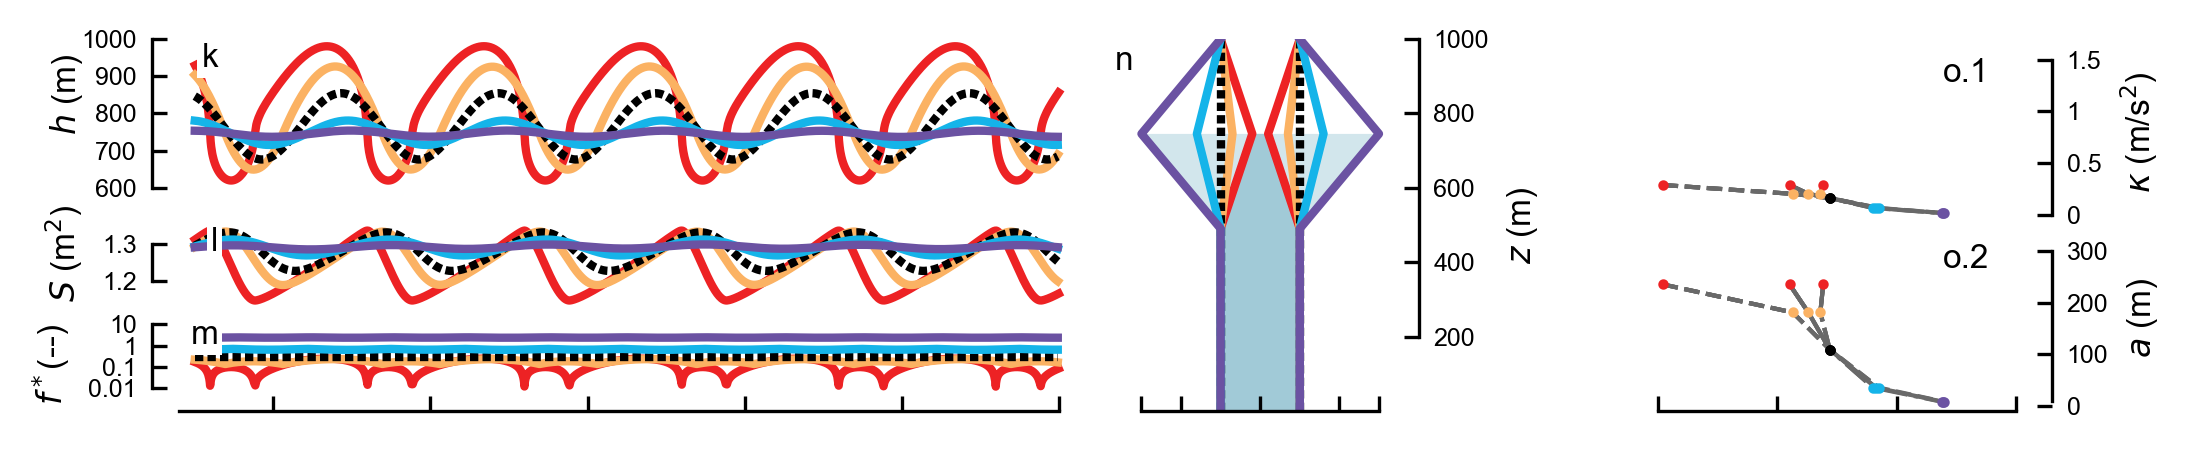

In [50]:
## LOSANGE fix at elsevec [1,3.5,5,8,15]
#r_heqvec= [1,3,5,15]#[1,3,5,7,10,15] #4colors
r_heqvec= [1,3.5,5,8,15]
r_else = 5
dh1 = param.H-h_eq#265 #distance from h_eq
dh2 = param.H-h_eq
linestyles = ('solid','solid',(0, (1, 0.5)),'solid')#4colors
linestyles = ('solid','solid',(0, (1, 0.5)),'solid','solid')
#colors = ((0,0,0),(0.4,0.4,0.4),(0.2,0.2,0.2),(0.7,0.7,0.7))
colors = (Red, Orange, (0,0,0), Blue, Purple)

#plt.figure()
fig = plt.figure(figsize=figsize_none, dpi=param.dpi, tight_layout=True)
grid = plt.GridSpec(gs_y, gs_x, wspace=0, hspace=0)
ax1 = fig.add_subplot(grid[0:2, :3])#,xticklabels=[]
ax2 = fig.add_subplot(grid[0:, 3])#, sharey=ax1)# , yticklabels=[])
ax3 = fig.add_subplot(grid[2, :3], sharex=ax1)
ax4 = fig.add_subplot(grid[3, :3], sharex=ax1)
ax5 = fig.add_subplot(grid[0:2, 4:])
ax6 = fig.add_subplot(grid[2:4, 4:])
#ax5 = fig.add_subplot(grid[0:2, 3])
#ax6 = fig.add_subplot(grid[2:4, 3], sharex=ax5)
#ax7 = fig.add_subplot(grid[0:2, 4])
#ax8 = fig.add_subplot(grid[2:4, 4], sharex=ax7)

polygon_1 = [[-r_else, r_else, r_else, r_heqvec[-1], -r_heqvec[-1], -r_else]
             ,[0, 0, h_eq-dh1, h_eq, h_eq, h_eq-dh1]]

polygon_2 = [[-r_else, r_else, r_else, r_heqvec[0], -r_heqvec[0], -r_else]
             ,[0, 0, h_eq-dh1, h_eq, h_eq, h_eq-dh1]]

d2hd_max_vec = []
a_vec = []
f_heq_vec = []
f_minmax_vec = []
f_average_vec = []

for i,r_heq in zip(range(len(r_heqvec)),r_heqvec): 
  
    tmp = diamond(dh1,dh2, r_else)
    z_moulin = tmp[0]
    r_moulin = tmp[1]
    
    
    if r_heq < r_else:
        r_min = r_heq # for the plot with t_min
    else:
        r_min = r_else
    
    sol = solve_ivp(dy_dt,(param.t0, param.tf),(param.h0,param.S0),method = 'LSODA',max_step = 10*60)
    hd = sol.y[0]
    Sd = sol.y[1]
    td = sol.t
    
    '''Extract index 1,2 and 5 days '''
    [idx1,idx2,idx5,idxpeaks, idxpeak] = get_index_slice(
        start_1=1.5,start_2=2.5,start_5=5.5,end_a=0.5,end_b=0,peak_decalage=20)
     
    [f, f_minmax, d2hd, d2hd_max, kurk_peak] = f_and_d2hdt()
    #print(f)
    AR = AR_func(hd)
    Qin = R_func(td)
    Qout = calculate_Qout(Sd,hd)
    QQ = Qin-Qout
    dhdt = np.diff(hd,prepend=0)    
    dadt = np.diff(dhdt,prepend=0)
    
    dfdt = df_dt(f,td)
    dfdz_up = df_dz_up(f,z_moulin,h_eq)
    
    a = calculate_amplitude(hd,h_eq)
    f_heq = calculate_f(h_eq)

    d2hd_max_vec.append(d2hd_max)
    a_vec.append(a)
    f_heq_vec.append(f_heq)
    f_minmax_vec.append(f_minmax)
    f_average_vec.append((f_heq+f_minmax)/2)
    
    plot_complex_fig(idx5[0],idx5[1],dadt)
    
    resdic ={'z_moulin':z_moulin, 'r_moulin':r_moulin,\
          'hd':hd, 'Sd':Sd, 'td':td, 'f':f,\
          'AR':AR, 'Qin':Qin, 'Qout':Qout}
    reslist.append(resdic)
    
    
add_letters(a='k',b='l',c='m',d='n',e='o.1',f='o.2',g='o.3',h='o.4')
add_label(position='middle')

plt.savefig('Figures/OR_lozange_else5m.pdf')


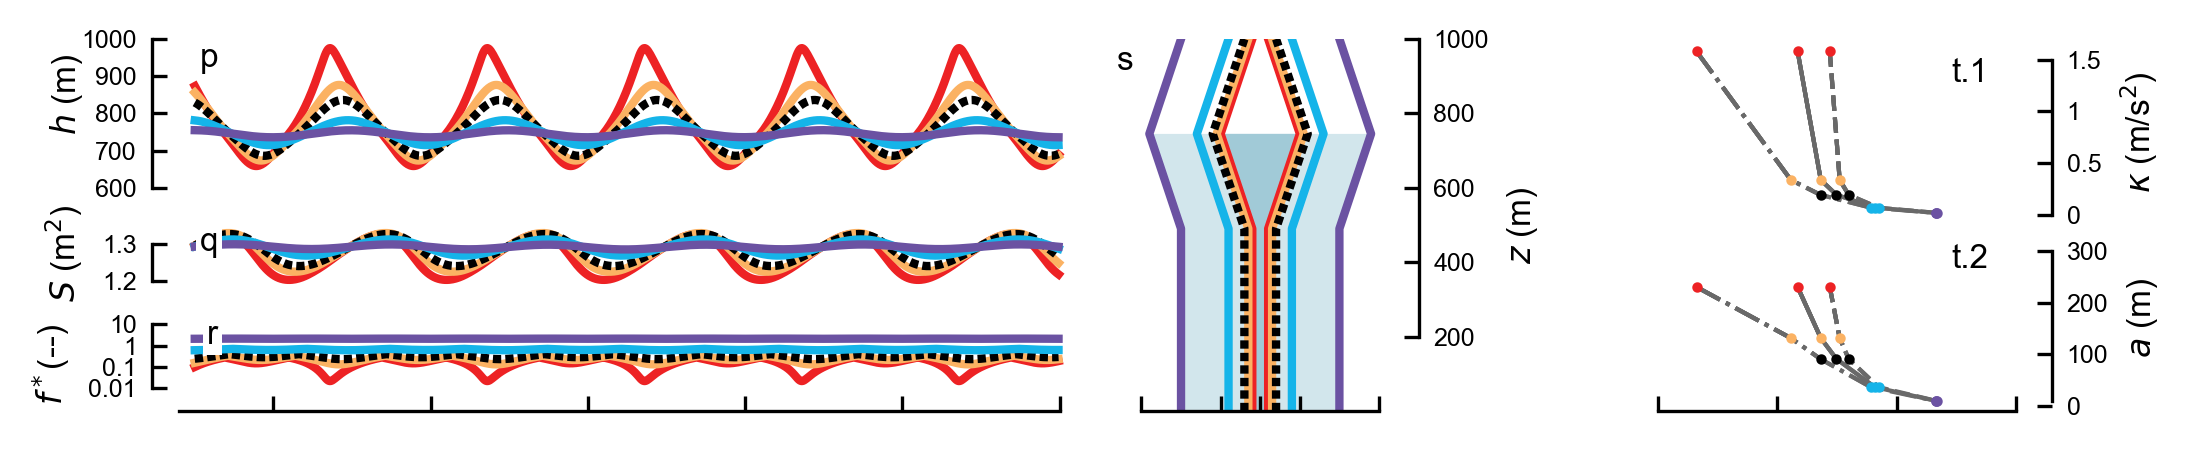

In [51]:
## LOSANGE  r_elsevec = [1,1.5,2,4,10] dif = 4

#r_elsevec = [1,2,4,10]#[1,1.5,3,5,10,15]#4colors
r_elsevec = [1,1.5,2,4,10]#[1,1.5,3,5,10,15]
dif = 4

param.R_mean = 3
param.R_min = 2.6

dh1 = param.H-h_eq#265 #distance from h_eq
dh2 = param.H-h_eq
#colors = ('#D55E00','#E69F00','#000000','#0072B2')
#colors = ((0,0,0),(0.4,0.4,0.4),(0.2,0.2,0.2),(0.7,0.7,0.7))
colors = (Red, Orange,(0,0,0), Blue, Purple)
#linestyles = ('solid','solid',(0, (1, 0.5)),'solid')#4colors
linestyles = ('solid','solid',(0, (1, 0.5)),'solid','solid')
#plt.figure()
fig = plt.figure(figsize=figsize_none, dpi=param.dpi, tight_layout=True)
grid = plt.GridSpec(gs_y, gs_x, wspace=0, hspace=0)
ax1 = fig.add_subplot(grid[0:2, :3])#,xticklabels=[]
ax2 = fig.add_subplot(grid[0:, 3])#, sharey=ax1)# , yticklabels=[])
ax3 = fig.add_subplot(grid[2, :3], sharex=ax1)
ax4 = fig.add_subplot(grid[3, :3], sharex=ax1)
ax5 = fig.add_subplot(grid[0:2, 4:])
ax6 = fig.add_subplot(grid[2:4, 4:])
#ax5 = fig.add_subplot(grid[0:2, 3])
#ax6 = fig.add_subplot(grid[2:4, 3], sharex=ax5)
#ax7 = fig.add_subplot(grid[0:2, 4])
#ax8 = fig.add_subplot(grid[2:4, 4], sharex=ax7)

polygon_1 = [[-r_elsevec[-1], r_elsevec[-1], r_elsevec[-1], r_elsevec[-1]+dif, -r_elsevec[-1]-dif, -r_elsevec[-1]]
             ,[0, 0, h_eq-dh1, h_eq, h_eq, h_eq-dh1]]

polygon_2 = [[-r_elsevec[0], r_elsevec[0], r_elsevec[0],  r_elsevec[0]+dif, -r_elsevec[0]-dif, -r_elsevec[0]]
             ,[0, 0, h_eq-dh1, h_eq, h_eq, h_eq-dh1]]

d2hd_max_vec = []
a_vec = []
f_heq_vec = []
f_minmax_vec = []
f_average_vec = []

for i,r_else in zip(range(len(r_elsevec)),r_elsevec): #for diamond 
    r_heq = r_else+dif
    tmp = diamond(dh1,dh2, r_else)
    z_moulin = tmp[0]
    r_moulin = tmp[1]
    #print(r_heq)

    r_min = r_else # for the plot with t_min

    
    sol = solve_ivp(dy_dt,(param.t0, param.tf),(param.h0,param.S0),method = 'LSODA',max_step = 10*60)
    hd = sol.y[0]
    Sd = sol.y[1]
    td = sol.t
    
    '''Extract index 1,2 and 5 days '''
    [idx1,idx2,idx5,idxpeaks,idxpeak] = get_index_slice(
        start_1=1.5,start_2=2.5,start_5=5.5,end_a=0.5,end_b=0,peak_decalage=20)
     
    [f, f_minmax, d2hd, d2hd_max, kurk_peak] = f_and_d2hdt()
    #print(f)
    AR = 1/AR_func(hd)
    Qin = R_func(td)
    Qout = calculate_Qout(Sd,hd)
    QQ = Qin-Qout
    dt = calculate_dt(td)
    dhdt = np.diff(hd,prepend=0)    
    dadt = np.diff(dhdt,prepend=0)
    
    dfdt = df_dt(f,td)
    dfdz_up = df_dz_up(f,z_moulin,h_eq)    
    a = calculate_amplitude(hd,h_eq)
    f_heq = calculate_f(h_eq)
    
    d2hd_max_vec.append(d2hd_max)
    a_vec.append(a)
    f_heq_vec.append(f_heq)
    f_minmax_vec.append(f_minmax)
    f_average_vec.append((f_heq+f_minmax)/2)
    
    plot_complex_fig(idx5[0],idx5[1],dadt)
    
    resdic ={'z_moulin':z_moulin, 'r_moulin':r_moulin,\
          'hd':hd, 'Sd':Sd, 'td':td, 'f':f,\
          'AR':AR, 'Qin':Qin, 'Qout':Qout}
    reslist.append(resdic)
    

add_letters(a='p',b='q',c='r',d='s',e='t.1',f='t.2',g='t.3',h='t.4') 
add_label(position='middle')

plt.savefig('Figures/OR_diamond_diff4m.pdf')



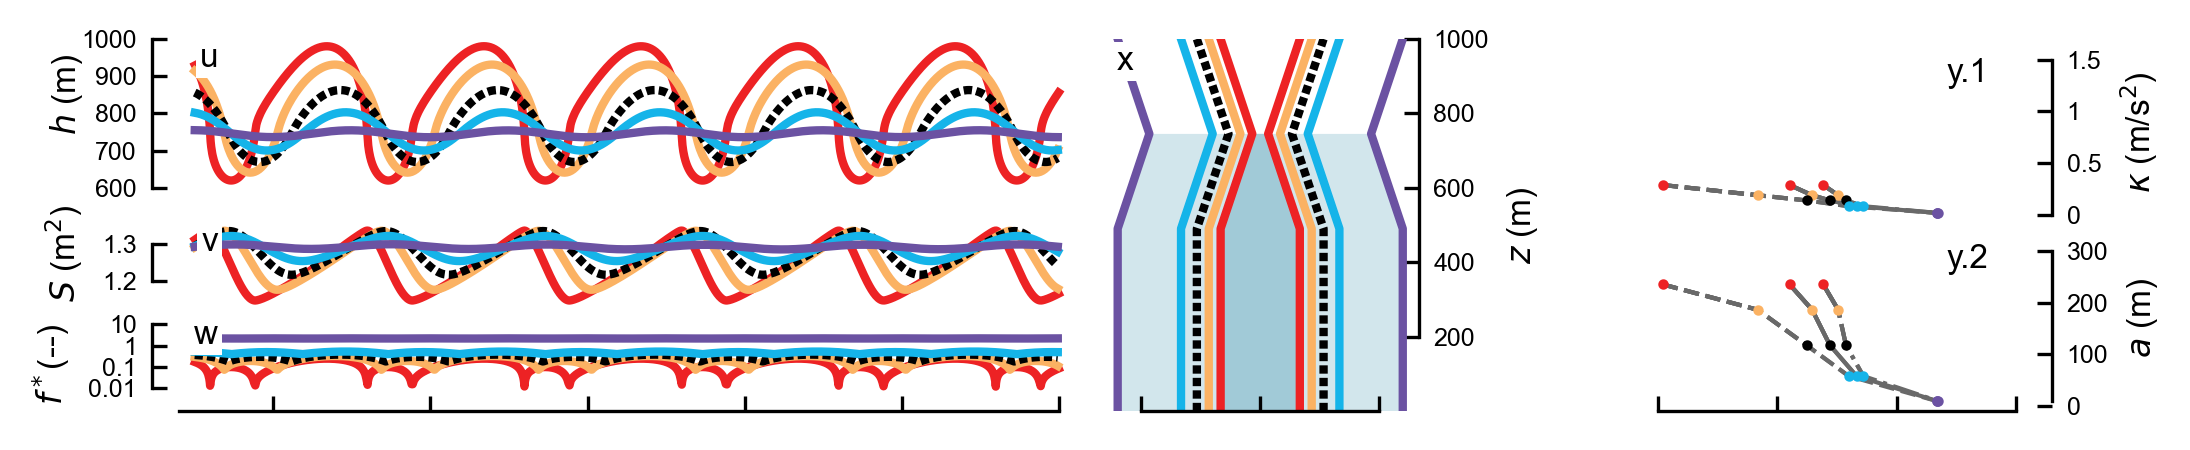

In [52]:
## LOSANGE

#r_elsevec = [5,7,10,18]#[1,1.5,3,5,10,15] # 4 colors
r_elsevec = [5,6.5,8,10,18]
dif = -4

dh1 = param.H-h_eq#265 #distance from h_eq
dh2 = param.H-h_eq
#colors = ('#D55E00','#E69F00','#000000','#0072B2')
#colors = ((0,0,0),(0.4,0.4,0.4),(0.2,0.2,0.2),(0.7,0.7,0.7))
colors = (Red, Orange,(0,0,0), Blue, Purple)

#linestyles = ('solid','solid',(0, (1, 0.5)),'solid')#4 colors
linestyles = ('solid','solid',(0, (1, 0.5)),'solid','solid')
#plt.figure()
fig = plt.figure(figsize=figsize_none, dpi=param.dpi, tight_layout=True)
grid = plt.GridSpec(gs_y, gs_x, wspace=0, hspace=0)
ax1 = fig.add_subplot(grid[0:2, :3])#,xticklabels=[]
ax2 = fig.add_subplot(grid[0:, 3])#, sharey=ax1)# , yticklabels=[])
ax3 = fig.add_subplot(grid[2, :3], sharex=ax1)
ax4 = fig.add_subplot(grid[3, :3], sharex=ax1)
ax5 = fig.add_subplot(grid[0:2, 4:])
ax6 = fig.add_subplot(grid[2:4, 4:])
#ax5 = fig.add_subplot(grid[0:2, 3])
#ax6 = fig.add_subplot(grid[2:4, 3], sharex=ax5)
#ax7 = fig.add_subplot(grid[0:2, 4])
#ax8 = fig.add_subplot(grid[2:4, 4], sharex=ax7)

polygon_1 = [[-r_elsevec[-1], r_elsevec[-1], r_elsevec[-1], r_elsevec[-1]+dif, -r_elsevec[-1]-dif, -r_elsevec[-1]]
             ,[0, 0, h_eq-dh1, h_eq, h_eq, h_eq-dh1]]

polygon_2 = [[-r_elsevec[0], r_elsevec[0], r_elsevec[0],  r_elsevec[0]+dif, -r_elsevec[0]-dif, -r_elsevec[0]]
             ,[0, 0, h_eq-dh1, h_eq, h_eq, h_eq-dh1]]

d2hd_max_vec = []
a_vec = []
f_heq_vec = []
f_minmax_vec = []
f_average_vec = []

for i,r_else in zip(range(len(r_elsevec)),r_elsevec): #for diamond 
    r_heq = r_else+dif
    tmp = diamond(dh1,dh2, r_else)
    z_moulin = tmp[0]
    r_moulin = tmp[1]
    #print(r_heq)
    r_min = r_heq # for the plot with t_min
    
    sol = solve_ivp(dy_dt,(param.t0, param.tf),(param.h0,param.S0),method = 'LSODA',max_step = 10*60)
    hd = sol.y[0]
    Sd = sol.y[1]
    td = sol.t
    
    '''Extract index 1,2 and 5 days '''
    [idx1,idx2,idx5,idxpeaks,idxpeak] = get_index_slice(
        start_1=1.5,start_2=2.5,start_5=5.5,end_a=0.5,end_b=0,peak_decalage=20)
     
    [f, f_minmax, d2hd, d2hd_max, kurk_peak] = f_and_d2hdt()
    #print(f)
    AR = AR_func(hd)
    Qin = R_func(td)
    Qout = calculate_Qout(Sd,hd)
    QQ = Qin-Qout
    dhdt = dydt(hd)
    dt = calculate_dt(td)
    dadt = dhdt/dt
    
    dfdt = df_dt(f,td)
    dfdz_up = df_dz_up(f,z_moulin,h_eq)
    
    a = calculate_amplitude(hd,h_eq)
    f_heq = calculate_f(h_eq)
    
    d2hd_max_vec.append(d2hd_max)
    a_vec.append(a)
    f_heq_vec.append(f_heq)
    f_minmax_vec.append(f_minmax)
    f_average_vec.append((f_heq+f_minmax)/2)
    
    plot_complex_fig(idx5[0],idx5[1],dhdt)
    
    resdic ={'z_moulin':z_moulin, 'r_moulin':r_moulin,\
          'hd':hd, 'Sd':Sd, 'td':td, 'f':f,\
          'AR':AR, 'Qin':Qin, 'Qout':Qout}
    reslist.append(resdic)
    

add_letters(a='u',b='v',c='w',d='x',e='y.1',f='y.2',g='y.3',h='y.4')  
add_label(position='middle')

plt.savefig('Figures/OR_hourglass_diff4m.pdf')


[5 5 3 3]
[5 5 4 4]
[5 5 5 5]
[5 5 6 6]
[ 5  5 10 10]


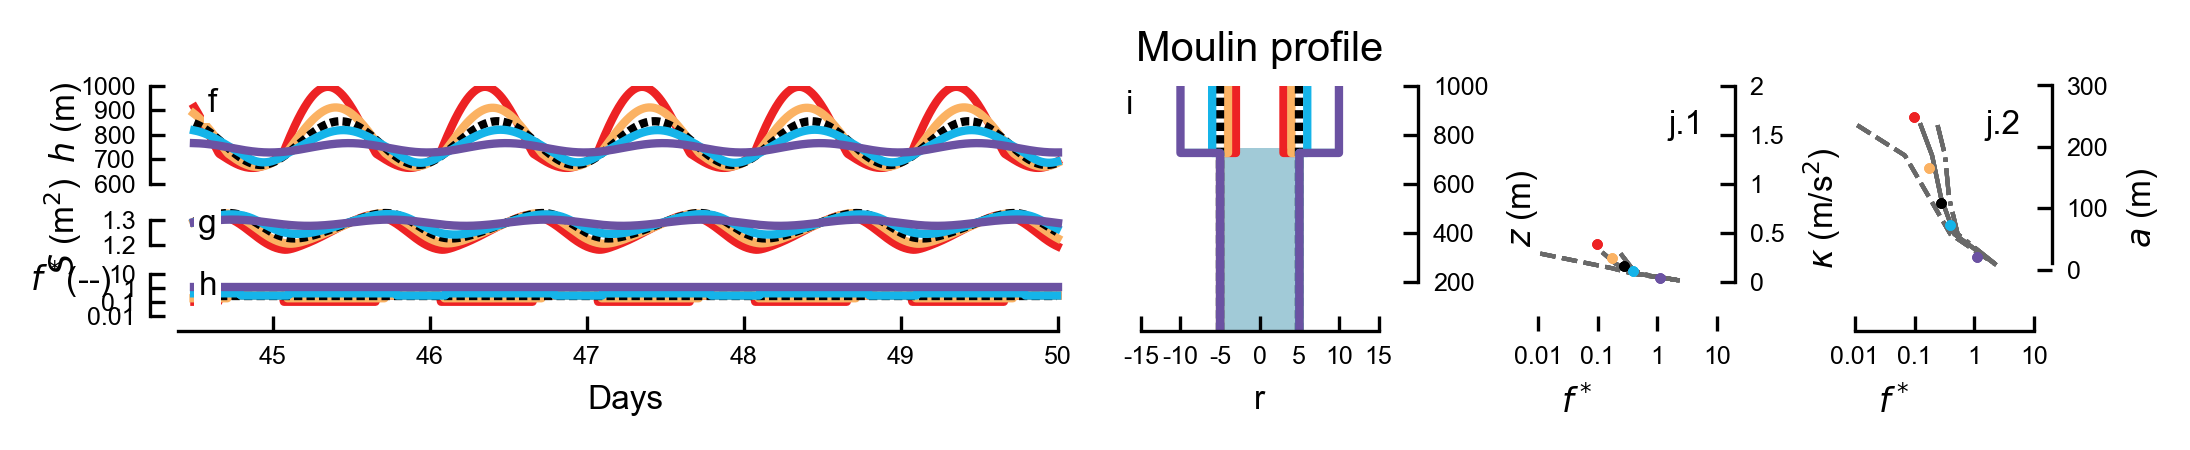

In [406]:
## demi-cylinder [3,4,5,7,10]
#r_heqvec = [3,5,7,10]#[4,6,8,9,10,12]#4colors
#r_heqvec = [3.5,4,5,8,15]
r_heqvec = [3,4,5,6,10]

r_else = 5
dh1 = 20 
dh2 = param.H-h_eq
#linestyles = ('solid',(0, (1, 0.5)),'solid','solid')#4colors
linestyles = ('solid','solid',(0, (1, 0.5)),'solid','solid')
#colors = ((0,0,0),(0.2,0.2,0.2),(0.4,0.4,0.4),(0.7,0.7,0.7))
colors = (Red, Orange,(0,0,0), Blue, Purple)

#plt.figure()
fig = plt.figure(figsize=figsize_none, dpi=param.dpi, tight_layout=True)
grid = plt.GridSpec(gs_y, gs_x, wspace=0, hspace=0)
ax1 = fig.add_subplot(grid[0:2, :3])#,xticklabels=[]
ax2 = fig.add_subplot(grid[0:, 3])#, sharey=ax1)# , yticklabels=[])
ax3 = fig.add_subplot(grid[2, :3], sharex=ax1)
ax4 = fig.add_subplot(grid[3, :3], sharex=ax1)
ax5 = fig.add_subplot(grid[0:, 4])
ax6 = fig.add_subplot(grid[0:, 5])
#ax5 = fig.add_subplot(grid[0:2, 3])
#ax6 = fig.add_subplot(grid[2:4, 3], sharex=ax5)
#ax7 = fig.add_subplot(grid[0:2, 4])
#ax8 = fig.add_subplot(grid[2:4, 4], sharex=ax7)

polygon_1 = [[-r_else, r_else, r_else, r_heqvec[-1], r_heqvec[-1], -r_heqvec[-1], -r_heqvec[-1], -r_else]
             ,[0, 0, h_eq-dh1, h_eq-dh1, h_eq, h_eq, h_eq-dh1, h_eq-dh1]]

polygon_2 = [[-r_else, r_else, r_else, r_heqvec[0], r_heqvec[0], -r_heqvec[0], -r_heqvec[0], -r_else]
             ,[0, 0, h_eq-dh1, h_eq-dh1, h_eq, h_eq, h_eq-dh1, h_eq-dh1]]


for i,r_heq in zip(range(len(r_heqvec)),r_heqvec): #for rectangle
  
    tmp = rectangle(dh1,dh2, r_else)
    z_moulin = tmp[0]
    r_moulin = tmp[1]
    
    
    
    if r_heq < r_else:
        r_min = r_heq # for the plot with t_min
    else:
        r_min = r_else
    
    sol = solve_ivp(dy_dt,(param.t0, param.tf),(param.h0,param.S0),method = 'LSODA',max_step = 10*60)
    hd = sol.y[0]
    Sd = sol.y[1]
    td = sol.t
    
    '''Extract index 1,2 and 5 days '''
    [idx1,idx2,idx5,idxpeaks,idxpeak] = get_index_slice(
        start_1=1.5,start_2=2.5,start_5=5.5,end_a=0.5,end_b=0,peak_decalage=20)
     
    [f, f_minmax, d2hd, d2hd_max, kurk_peak] = f_and_d2hdt()

    AR = AR_func(hd)
    Qin = R_func(td)
    Qout = calculate_Qout(Sd,hd)
    QQ = Qin-Qout
    dhdt = np.diff(hd,prepend=0)    
    dadt = np.diff(dhdt,prepend=0)
    
    dfdt = df_dt(f,td)
    dfdz_up = df_dz_up(f,z_moulin,h_eq)
    
    a = calculate_amplitude(hd,h_eq)
    f_heq = calculate_f(h_eq)
    
    plot_complex_fig(idx5[0],idx5[1],dadt)
    
    print(r_moulin)
    
    resdic ={'z_moulin':z_moulin, 'r_moulin':r_moulin,\
          'hd':hd, 'Sd':Sd, 'td':td, 'f':f,\
          'AR':AR, 'Qin':Qin, 'Qout':Qout}
    reslist.append(resdic)

    
add_letters(a='f',b='g',c='h',d='i',e='j.1',f='j.2',g='j.3',h='j.4')
add_label(position='none')

plt.savefig('Figures/OR_demi-cylinder_else35m.pdf')


<ipython-input-407-66138e05c899>:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "mode" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('Figures/OR_demi_cylinder_bottom.pdf',mode='rgb')


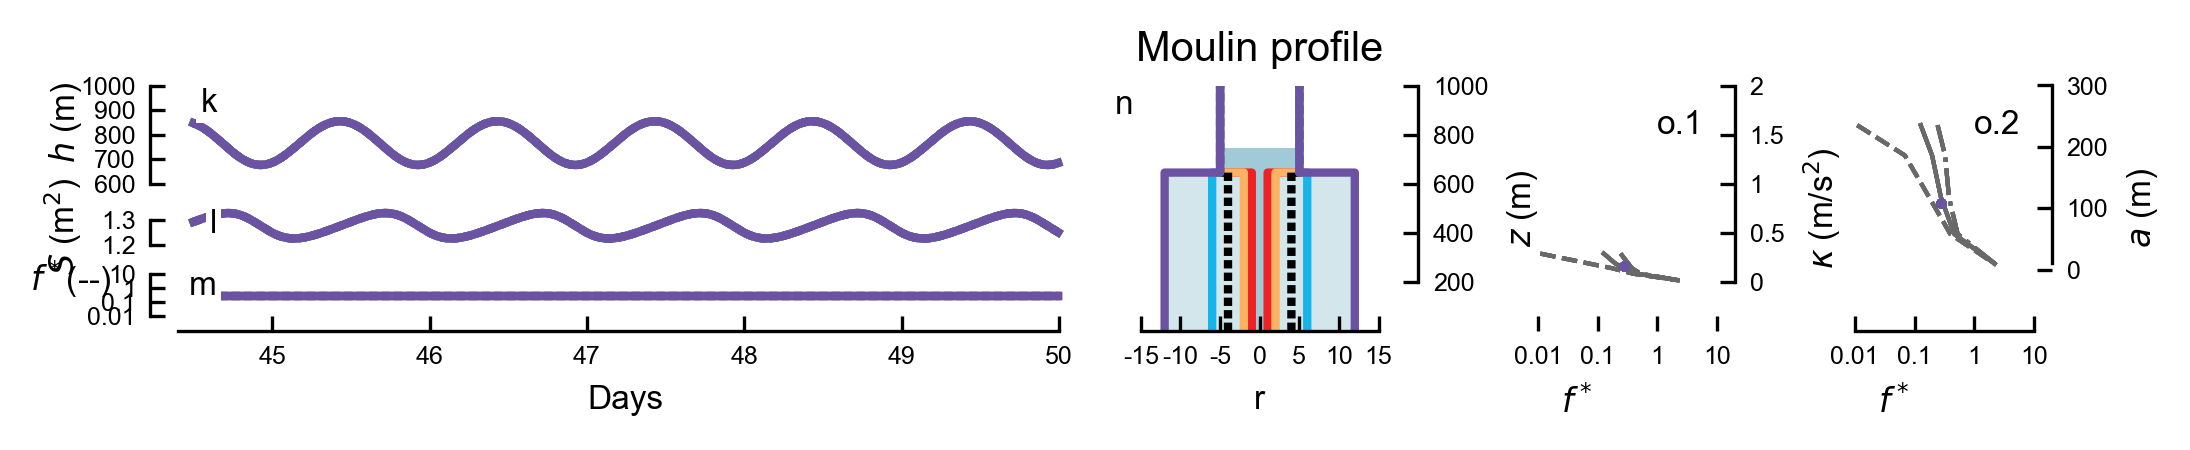

In [407]:
#r_elsevec = [1,2,4,10]#[1,1.5,3,5,10,15]#4colors
r_elsevec = [1,2,4,6,12]#[1,1.5,3,5,10,15]
r_heq = 5

dh1 = 100#265 #distance from h_eq
dh2 = param.H-h_eq
#colors = ('#D55E00','#E69F00','#000000','#0072B2')
#colors = ((0,0,0),(0.4,0.4,0.4),(0.2,0.2,0.2),(0.7,0.7,0.7))
colors = (Red, Orange,(0,0,0), Blue, Purple)
#linestyles = ('solid','solid',(0, (1, 0.5)),'solid')#4colors
linestyles = ('solid','solid',(0, (1, 0.5)),'solid','solid')
#plt.figure()
fig = plt.figure(figsize=figsize_none, dpi=param.dpi, tight_layout=True)
grid = plt.GridSpec(gs_y, gs_x, wspace=0, hspace=0)
ax1 = fig.add_subplot(grid[0:2, :3])#,xticklabels=[]
ax2 = fig.add_subplot(grid[0:, 3])#, sharey=ax1)# , yticklabels=[])
ax3 = fig.add_subplot(grid[2, :3], sharex=ax1)
ax4 = fig.add_subplot(grid[3, :3], sharex=ax1)
ax5 = fig.add_subplot(grid[0:, 4])
ax6 = fig.add_subplot(grid[0:, 5])
#ax5 = fig.add_subplot(grid[0:2, 3])
#ax6 = fig.add_subplot(grid[2:4, 3], sharex=ax5)
#ax7 = fig.add_subplot(grid[0:2, 4])
#ax8 = fig.add_subplot(grid[2:4, 4], sharex=ax7)

polygon_1 = [[-r_elsevec[-1], r_elsevec[-1], r_elsevec[-1], r_heq, r_heq, -r_heq, -r_heq, -r_elsevec[-1]]
              ,[0, 0, h_eq-dh1, h_eq-dh1, h_eq, h_eq, h_eq-dh1, h_eq-dh1]]


polygon_2 = [[-r_elsevec[0], r_elsevec[0], r_elsevec[0],   r_heq, r_heq, -r_heq, -r_heq, -r_elsevec[0]]
             ,[0, 0, h_eq-dh1, h_eq-dh1, h_eq, h_eq, h_eq-dh1, h_eq-dh1]]

for i,r_else in zip(range(len(r_elsevec)),r_elsevec): #for diamond 

    tmp = rectangle(dh1,dh2, r_else)
    z_moulin = tmp[0]
    r_moulin = tmp[1]
    

    r_min = r_else # for the plot with t_min

    
    sol = solve_ivp(dy_dt,(param.t0, param.tf),(param.h0,param.S0),method = 'LSODA',max_step = 10*60)
    hd = sol.y[0]
    Sd = sol.y[1]
    td = sol.t
    
    '''Extract index 1,2 and 5 days '''
    [idx1,idx2,idx5,idxpeaks,idxpeak] = get_index_slice(
        start_1=1.5,start_2=2.5,start_5=5.5,end_a=0.5,end_b=0,peak_decalage=20)
     
    [f, f_minmax, d2hd, d2hd_max, kurk_peak] = f_and_d2hdt()
    #print(f)
    AR = AR_func(hd)
    Qin = R_func(td)
    Qout = calculate_Qout(Sd,hd)
    QQ = Qin-Qout
    dhdt = dydt(hd)
    dt = calculate_dt(td)
    dadt = dhdt/dt
    
    dfdt = df_dt(f,td)
    dfdz_up = df_dz_up(f,z_moulin,h_eq)
    
    a = calculate_amplitude(hd,h_eq)
    f_heq = calculate_f(h_eq)
    
    plot_complex_fig(idx5[0],idx5[1],dhdt)
    
    resdic ={'z_moulin':z_moulin, 'r_moulin':r_moulin,\
          'hd':hd, 'Sd':Sd, 'td':td, 'f':f,\
          'AR':AR, 'Qin':Qin, 'Qout':Qout}
    reslist.append(resdic)
    

add_letters(a='k',b='l',c='m',d='n',e='o.1',f='o.2',g='o.3',h='o.4') 
add_label(position='none')

plt.savefig('Figures/OR_demi_cylinder_bottom.pdf',mode='rgb')



NameError: name 'r_top' is not defined

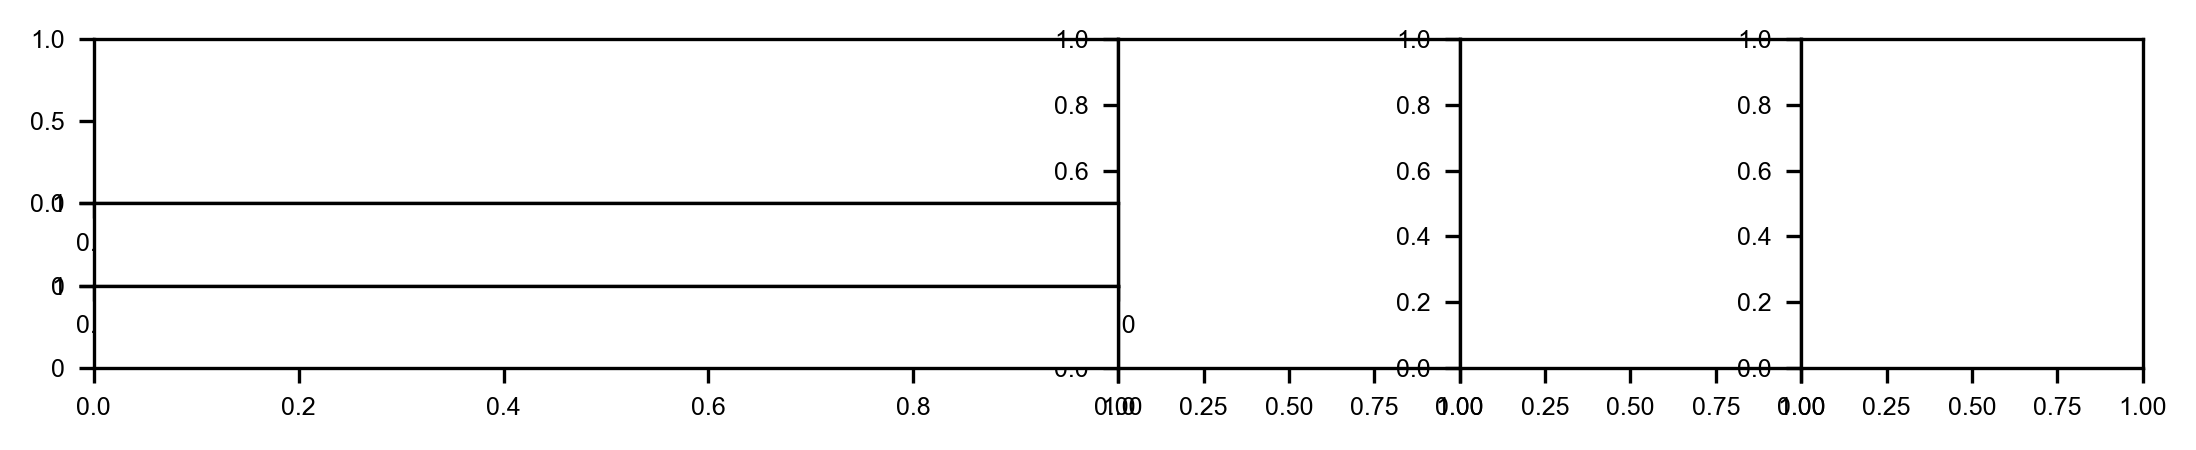

In [408]:
## cone 
m = [-0.06,
      -0.03,
      0,
      0.03,
      0.06]
r_fix = 8
z_fix = h_eq

linestyles = ('solid','solid',(0, (1, 0.5)),'solid','solid')
colors = (Red, Orange,(0,0,0), Blue, Purple)

#plt.figure()
fig = plt.figure(figsize=figsize_none, dpi=param.dpi, tight_layout=True)
grid = plt.GridSpec(gs_y, gs_x, wspace=0, hspace=0)
ax1 = fig.add_subplot(grid[0:2, :3])#,xticklabels=[]
ax2 = fig.add_subplot(grid[0:, 3])#, sharey=ax1)# , yticklabels=[])
ax3 = fig.add_subplot(grid[2, :3], sharex=ax1)
ax4 = fig.add_subplot(grid[3, :3], sharex=ax1)
ax5 = fig.add_subplot(grid[0:, 4])
ax6 = fig.add_subplot(grid[0:, 5])
#ax5 = fig.add_subplot(grid[0:2, 3])
#ax6 = fig.add_subplot(grid[2:4, 3], sharex=ax5)
#ax7 = fig.add_subplot(grid[0:2, 4])
#ax8 = fig.add_subplot(grid[2:4, 4], sharex=ax7)

polygon_1 = [[-r_top[0], r_top[0], r_top[0], -r_top[0]]
             ,[0, 0, h_eq, h_eq,]]

polygon_2 = [[-r_top[0], r_top[0], r_top[0], -r_top[0] ]
             ,[0, 0, h_eq, h_eq]]

for i in np.arange(len(m)): #for diamond
  
    tmp = cone(r_fix, z_fix, m[i])
    z_moulin = tmp[0]
    r_moulin = tmp[1]
    

    r_min = r_bottom # for the plot with t_min

    
    sol = solve_ivp(dy_dt,(param.t0, param.tf),(param.h0,param.S0),method = 'LSODA',max_step = 10*60)
    hd = sol.y[0]
    Sd = sol.y[1]
    td = sol.t
    
    '''Extract index 1,2 and 5 days '''
    [idx1,idx2,idx5,idxpeaks, idxpeak] = get_index_slice(
        start_1=1.5,start_2=2.5,start_5=5.5,end_a=0.5,end_b=0,peak_decalage=20)
     
    [f, f_minmax, d2hd, d2hd_max, kurk_peak] = f_and_d2hdt()
    #print(f)
    AR = AR_func(hd)
    Qin = R_func(td)
    Qout = calculate_Qout(Sd,hd)
    QQ = Qin-Qout
    dt = calculate_dt(td)
    dhdt = dydt(hd)
    dadt = dhdt/dt
    
    dfdt = df_dt(f,td)
    dfdz_up = df_dz_up(f,z_moulin,h_eq)

    a = calculate_amplitude(hd,h_eq)
    f_heq = calculate_f(h_eq)
    #plt.plot(td,dhdt)
    #plt.plot(td,dadt)
    plot_complex_fig(idx5[0],idx5[1],QQ)

    #plt.plot(f_minmax,amplitude,'o')
    
    resdic ={'z_moulin':z_moulin, 'r_moulin':r_moulin,\
              'hd':hd, 'Sd':Sd, 'td':td, 'f':f,\
              'AR':AR, 'Qin':Qin, 'Qout':Qout}
    reslist.append(resdic)


    
add_letters(a='a',b='b',c='c',d='d',e='e.1',f='e.2',g='e.3',h='e.4')
add_label(position='none')


plt.savefig('Figures/OR_CONE.pdf')




In [ ]:
print(r_moulin)

In [ ]:
type(r_top[i])

In [ ]:
type(r_bottom)

In [ ]:
i